In [16]:
from scipy import linalg
import json
import h5py
import os
import plot_SNVM_data as pSd
import SNVM_B_xyz_extraction as SBex
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib_scalebar.scalebar import ScaleBar
from math import ceil,floor,pi
import colorsys
import cv2
from skimage.util.shape import view_as_blocks
from skimage.io import imsave
from scipy.optimize import curve_fit
import scipy.odr as odr
import scipy.special
import warnings
from sklearn.preprocessing import normalize

In [34]:
def exponential(t,A0,tau,t0,C):
    return A0*np.exp(-(t-t0)/tau)+C
def exponentialNot0(t,A0,tau,C):
    return A0*np.exp(-(t)/tau)+C
#def odrexp(B,t):
#    return B[0]*np.exp(-(t-B[2])/B[1])+B[3]
def odrexp(B,t):
    return B[0]*np.exp(-(t)/B[1])+B[2]
def twotopow(t,A0,tau,t0,C):
    return A0*np.power(2,(-(t-t0)/tau))+C
def tentopow(t,A0,tau,t0,C):
    return A0*np.power(10,(-(t-t0)/tau))+C
def fiftytopow(t,A0,tau,t0,C):
    return A0*np.power(50,(-(t-t0)/tau))+C
def logofexpNot0(t,A0,tau,C):
    return np.log(A0*np.exp(-(t)/tau)+C)
def logofexp(t,A0,tau,t0,C):
    return np.log(A0*np.exp(-(t-t0)/tau)+C)
def noCexp(t,A0,tau):
    return(A0*np.exp(-t/tau))
def gaussian_pdf(x,sigma,mu):
    return(1/(sigma*np.sqrt(2*np.pi))*np.exp((x-mu)**2/(2*sigma**2)))
def gaussian(x,x0,a,b):
    return(a*np.exp((x-x0)**2/(2*b**2)))
def poisson(x,lam,a,x0):
    return(a*np.power(lam,(x-x0))/scipy.special.factorial(x-x0)*np.exp(-lam))
def poissonNoFact(x,lam,a,x0):
    return(a*np.power(lam,(x-x0))*np.exp(-lam))

In [6]:
# List all items in basepath
basepath = '/home/julisko/Seafile/My Library/SNVM/20230713_QZabre_Visit_Garnets_Rose/230713_18_QZabre_BiYIG_DyIG_Rose'
basepath_folders = []
basepath_foldernames = []

for i in range(len(os.listdir(basepath))):
    if os.path.isdir(basepath+'/'+sorted(os.listdir(basepath))[i]):
        basepath_folders.append(basepath+'/'+sorted(os.listdir(basepath))[i])
        basepath_foldernames.append(sorted(os.listdir(basepath))[i])
print(basepath_foldernames)


for i in range(len(basepath_folders)):
        
    if basepath_foldernames[i] =='Magnetometry_Scans':
        Magnetometry_dayfolders = [basepath_folders[i]+'/'+s for s in sorted(os.listdir(basepath_folders[i]))]
        print('Magnetometry_Scans','\n',sorted(os.listdir(basepath_folders[i])))
        
    if basepath_foldernames[i] =='Pulse_Experiments':
        Pulse_exp_dayfolders = [basepath_folders[i]+'/'+s for s in sorted(os.listdir(basepath_folders[i]))]
        print('Pulse_Experiments','\n',sorted(os.listdir(basepath_folders[i])))
        

['AFM_Scans', 'Confocal_Scans', 'Magnetometry_Scans', 'Pulse_Experiments']
Magnetometry_Scans 
 ['2023-07-13', '2023-07-14', '2023-07-15', '2023-07-16', '2023-07-17', '2023-07-18']
Pulse_Experiments 
 ['2023-07-13', '2023-07-14', '2023-07-15', '2023-07-16', '2023-07-17']


/run/user/1000/app/org.jupyter.JupyterLab/ipykernel_214/3024141212.py:2: RuntimeWarning: overflow encountered in exp
  return A0*np.exp(-(t-t0)/tau)+C


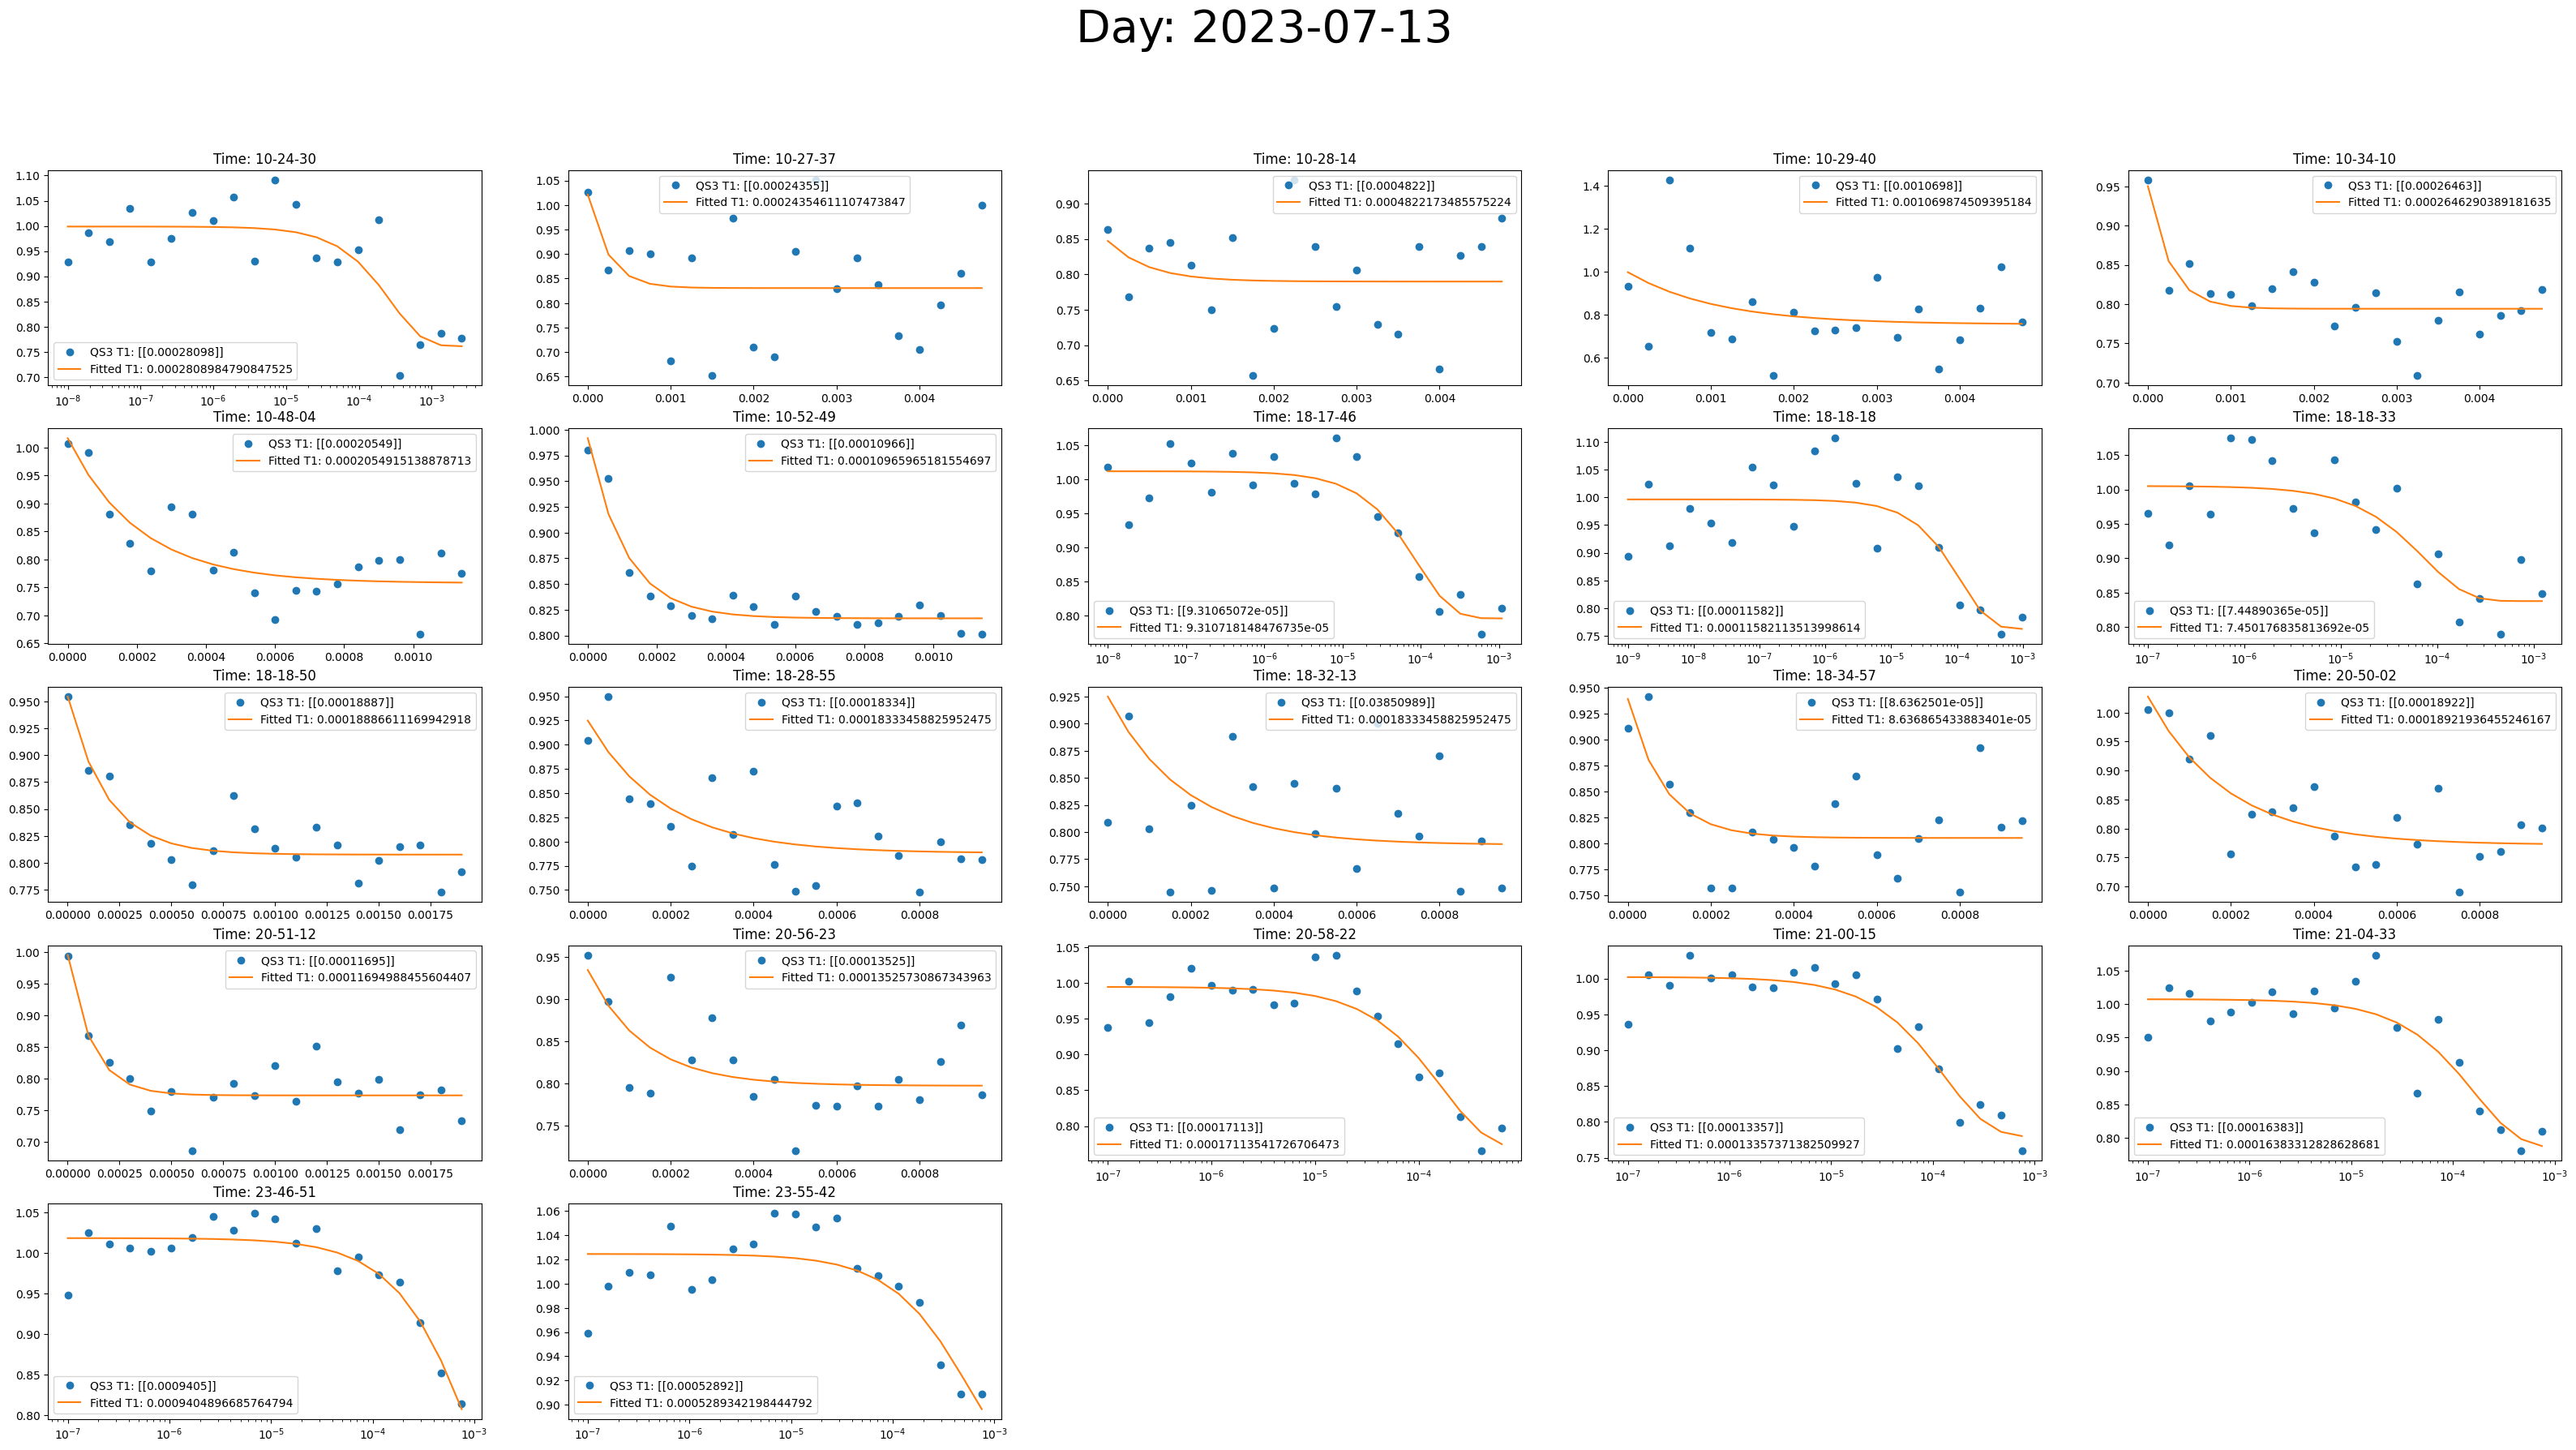

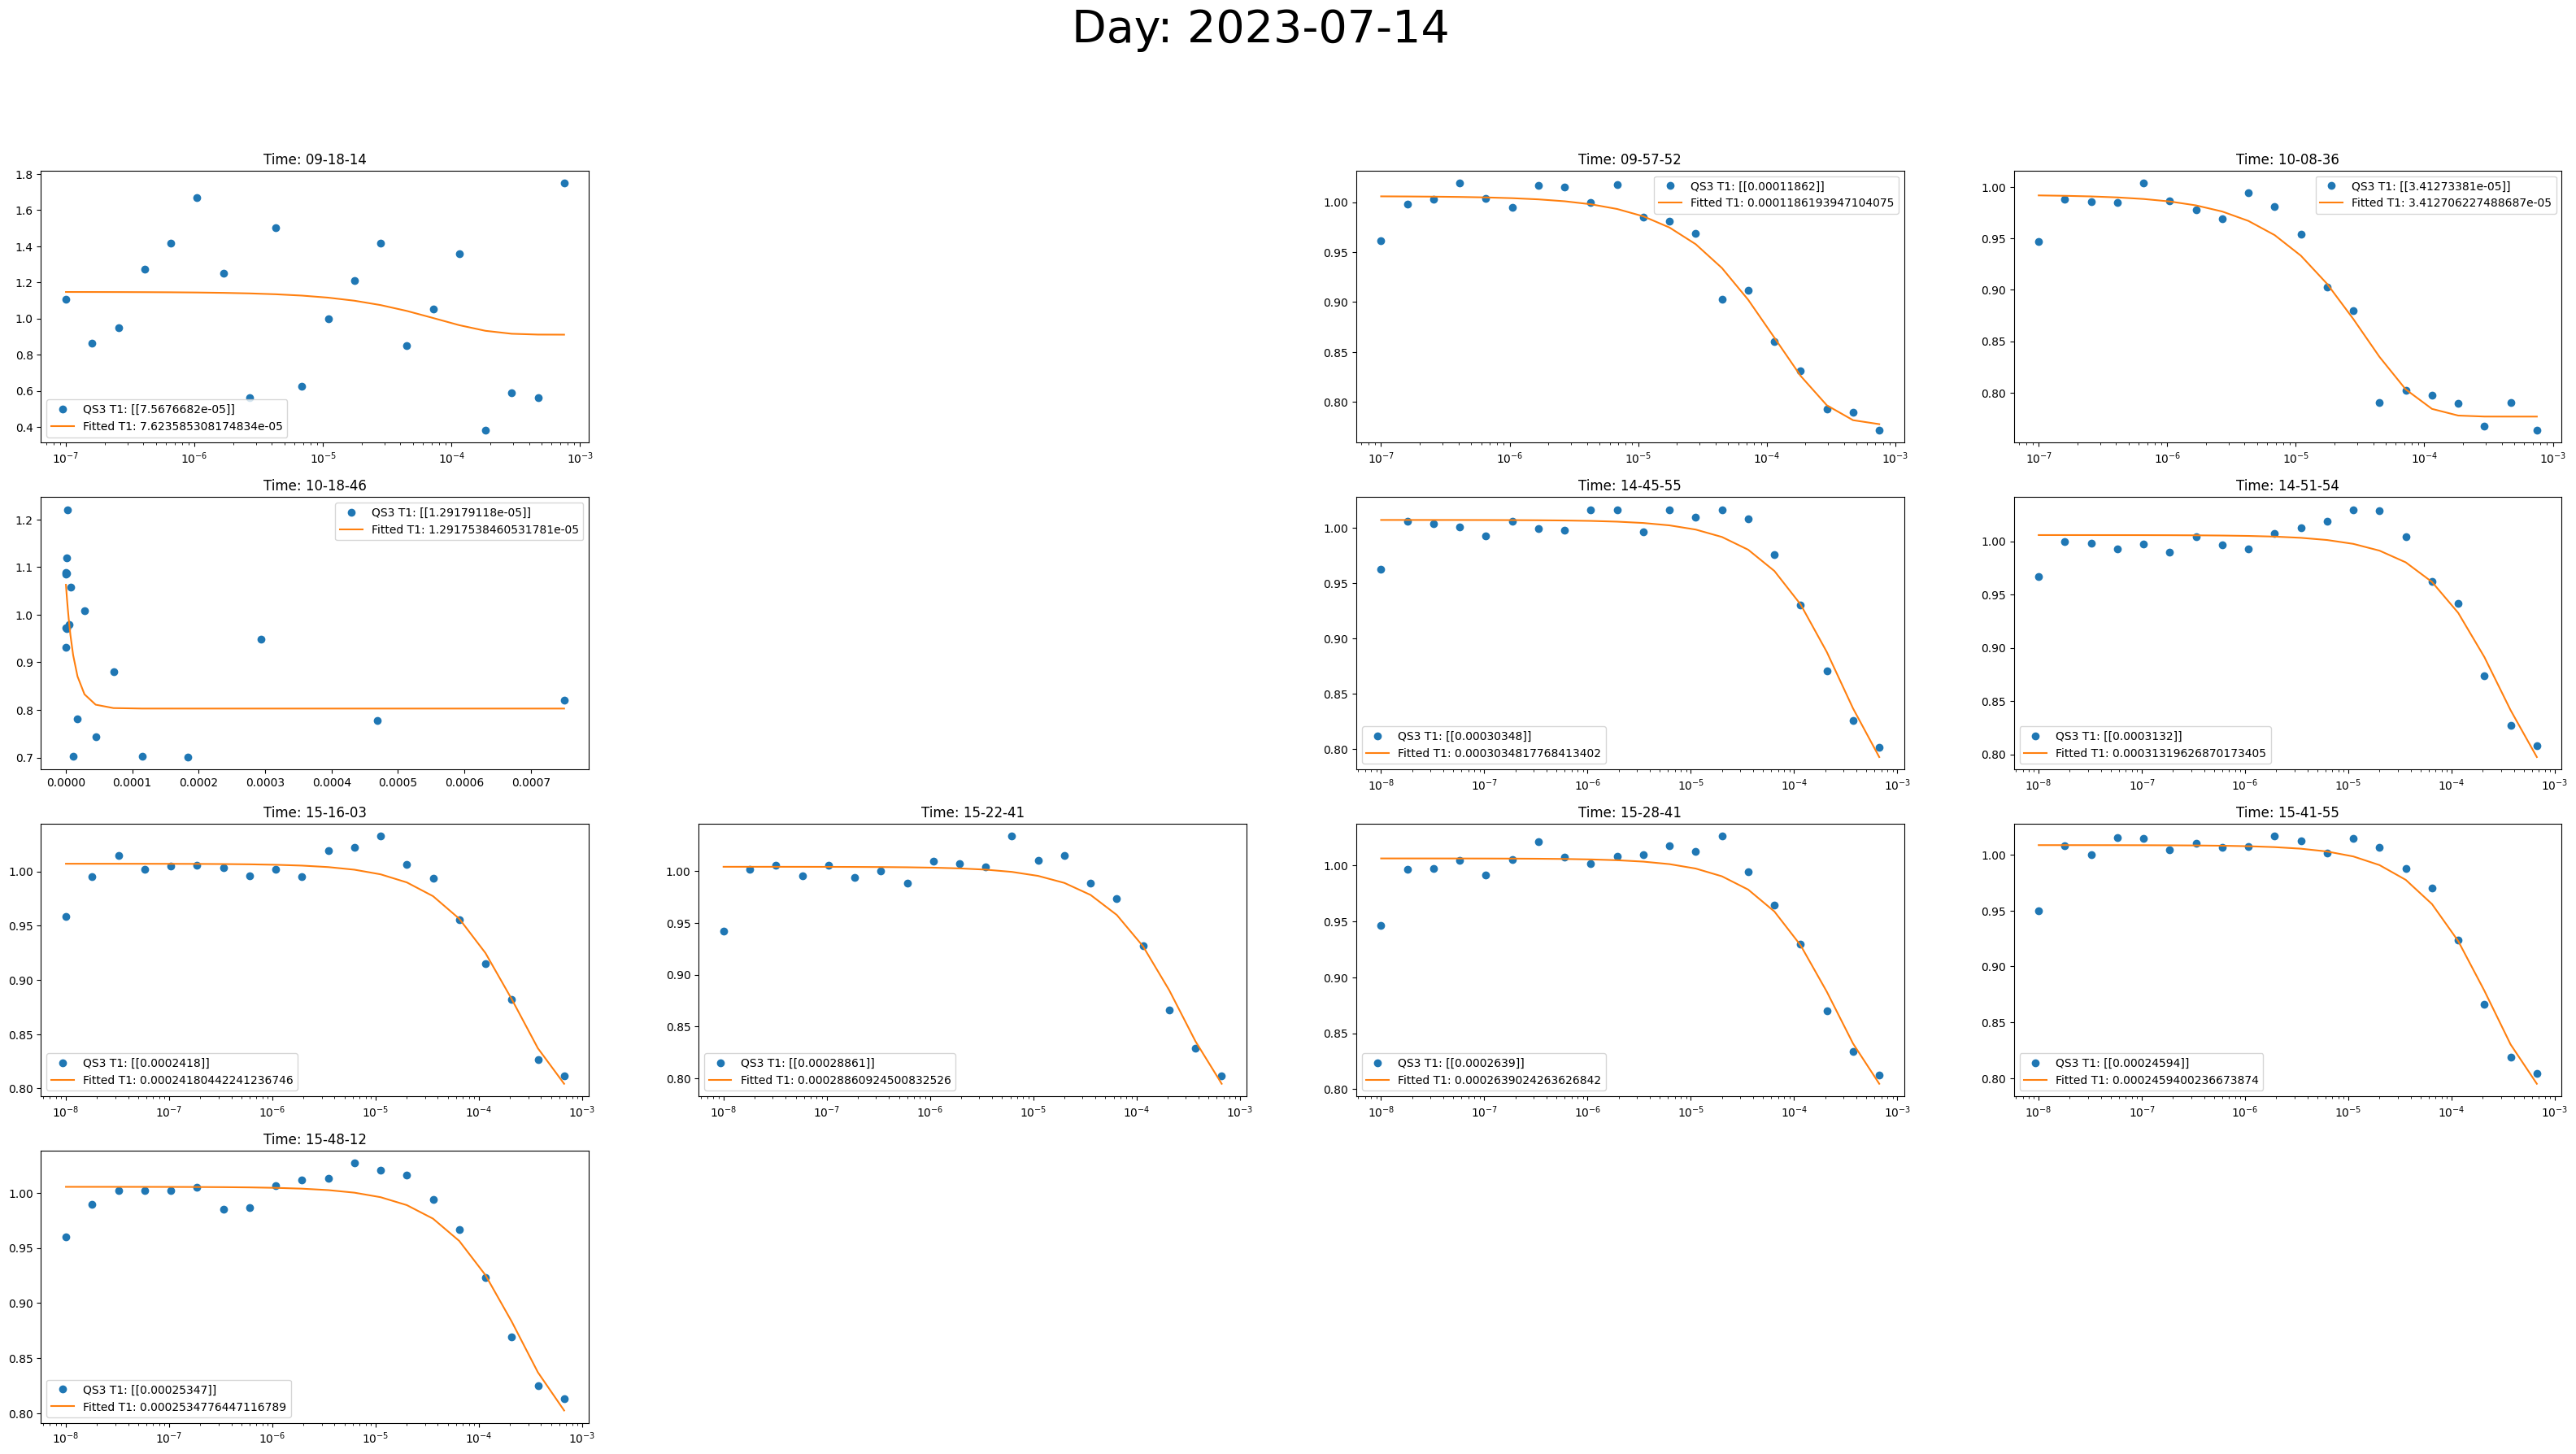

<Figure size 4000x2000 with 0 Axes>

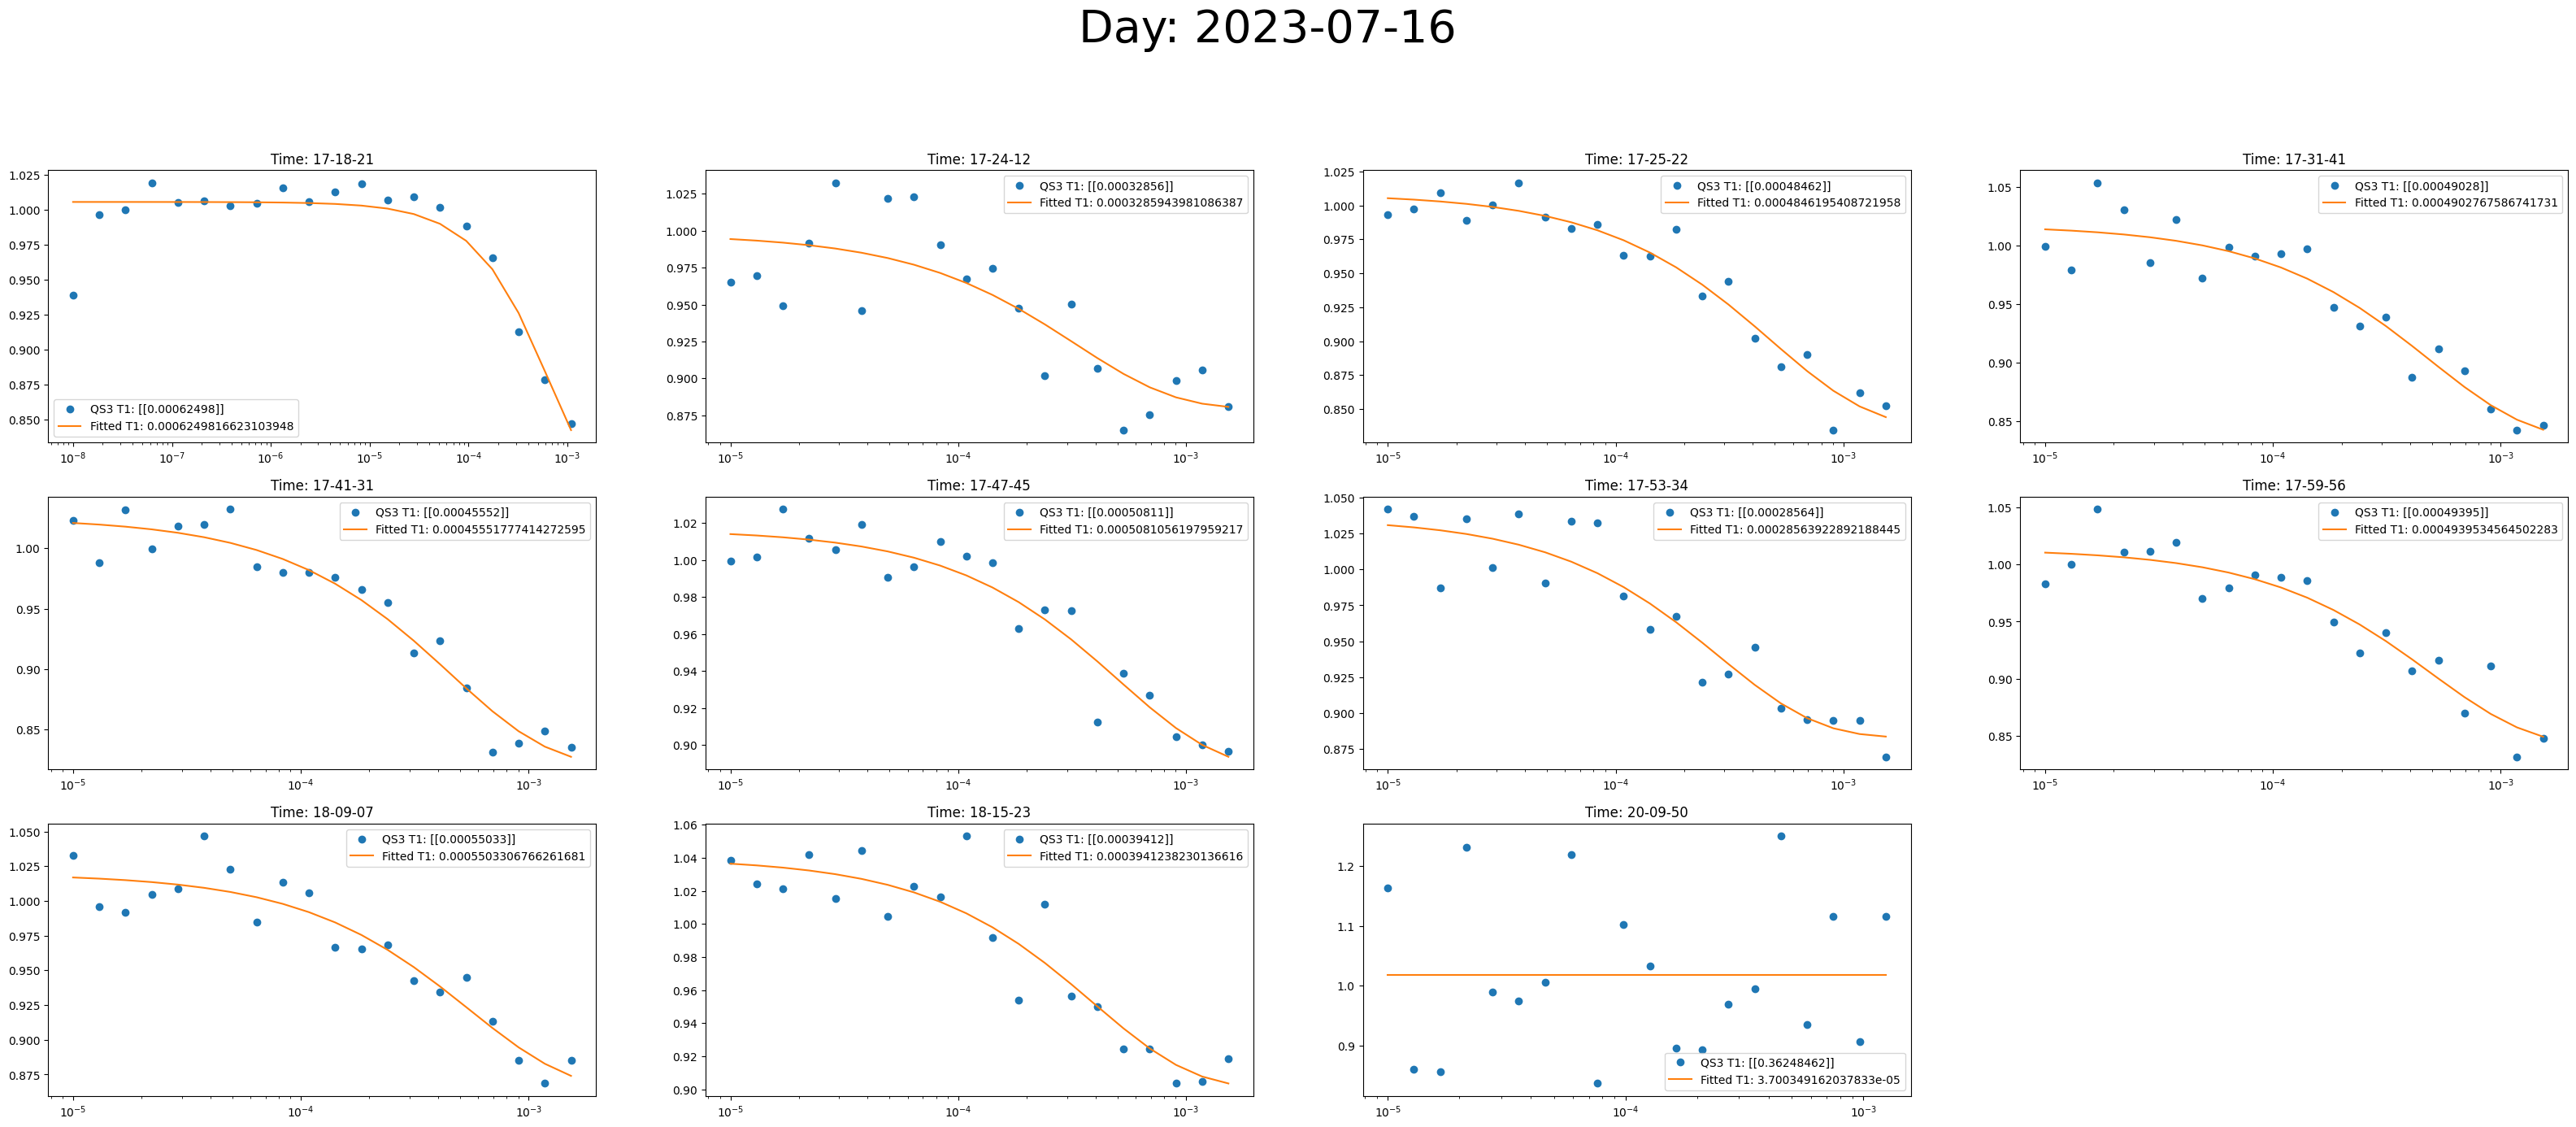

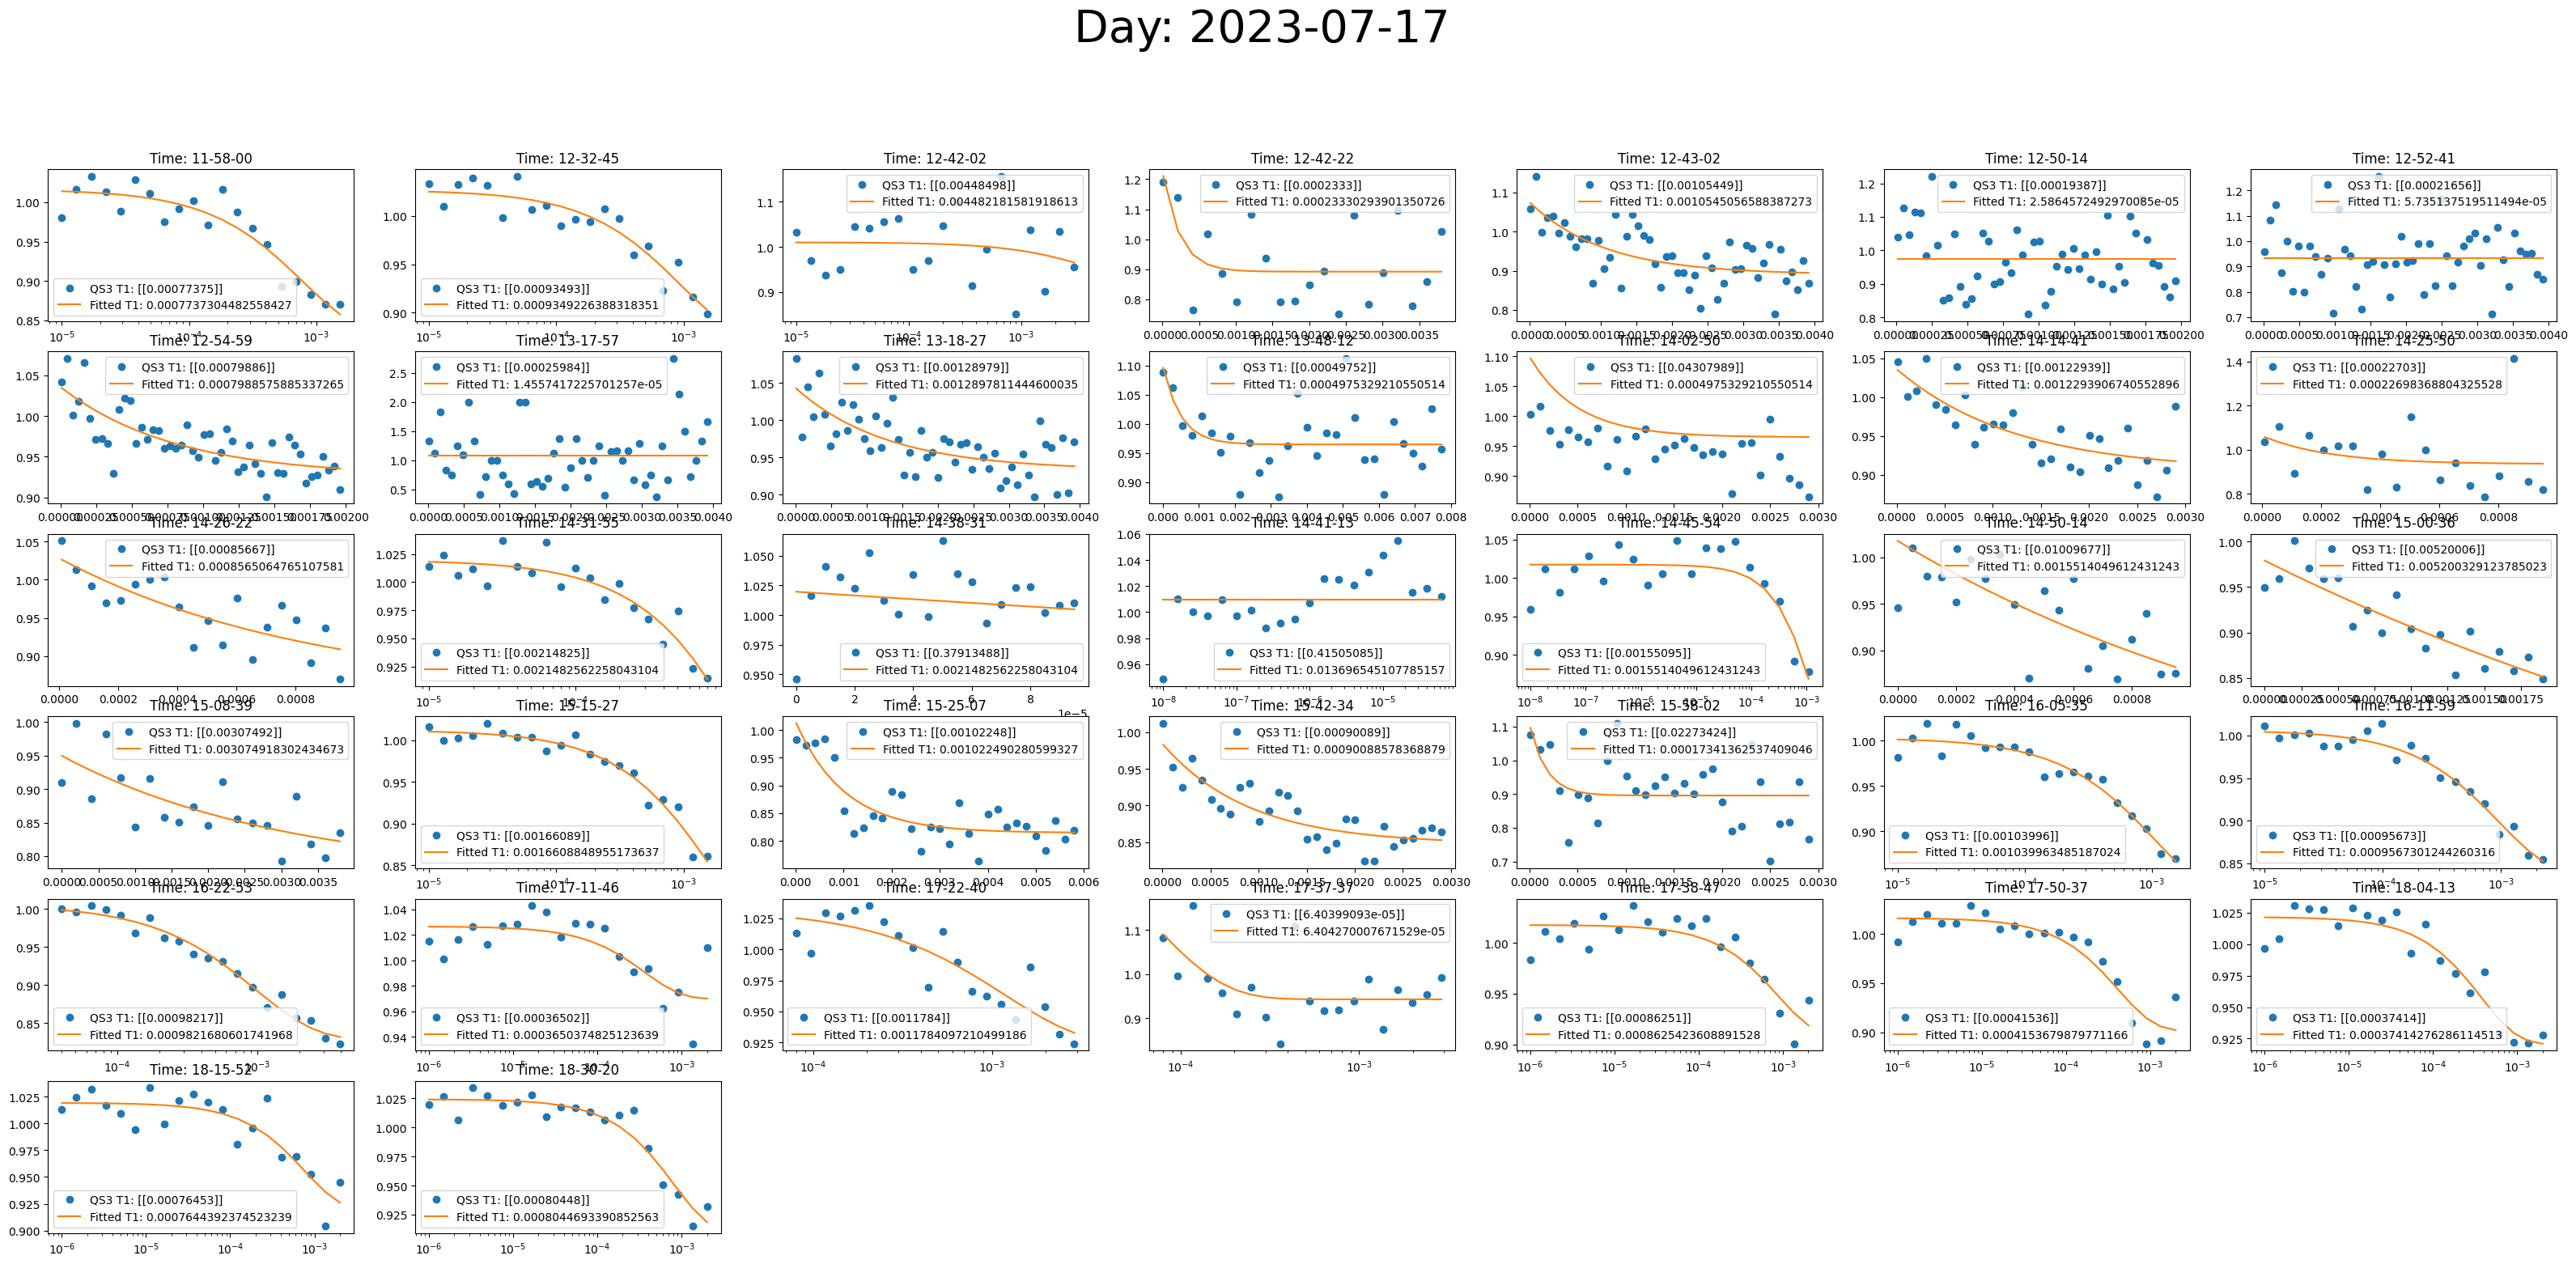

In [4]:
#read and plot all pulse experiment data 

savefolder = '/home/julisko/Seafile/My Library/SNVM/20230713_QZabre_Visit_Garnets_Rose/230713_18_QZabre_Analysis/Relaxometry'

Pulse_exp_folders = len(Pulse_exp_dayfolders)*[[]]

for Pulse_exp_dayfolders_index in range(len(Pulse_exp_dayfolders)):
    if os.path.isdir(Pulse_exp_dayfolders[Pulse_exp_dayfolders_index]+'/relaxation_laser'):
        Pulse_exp_folders[Pulse_exp_dayfolders_index] = [Pulse_exp_dayfolders[Pulse_exp_dayfolders_index]
                                                        +'/relaxation_laser/'+s 
                                                         for s in sorted(os.listdir(Pulse_exp_dayfolders[
                                                             Pulse_exp_dayfolders_index]+'/relaxation_laser'))]
        #print('\n')
        #print(Pulse_exp_folders[Pulse_exp_dayfolders_index])

nr_of_meas = 0
for day_index in range(len(Pulse_exp_folders)):
    for measurement_index in range(len(Pulse_exp_folders[day_index])):
        nr_of_meas+=1

fig_arr = []
nr_meas_perday = []
        
for day_index in range(len(Pulse_exp_folders)):
    
    #print(len(Pulse_exp_folders[day_index]),Pulse_exp_dayfolders[day_index])
    nr_meas_perday.append(len(Pulse_exp_folders[day_index]))
    fig = plt.figure(figsize = (40,20))
    plt.suptitle('Day: ' + str(Pulse_exp_dayfolders[day_index][-10:]),fontsize=40)
    fig_arr.append(fig)
    
    for measurement_index in range(len(Pulse_exp_folders[day_index])):
        #print(Pulse_exp_folders[day_index][measurement_index])
        h5file = h5py.File(Pulse_exp_folders[day_index][measurement_index]+'/seq0/eval/Relaxation.h5')
        
        delays = pSd.ExtractData(h5file, datatype = 'delay')[0][0]
        ms0s = pSd.ExtractData(h5file, datatype = 'ms0')[0][0]
        ref0s = pSd.ExtractData(h5file, datatype = 'ref0')[0][0]
        contrasts = pSd.ExtractData(h5file, datatype = 'contrastms0')[0][0]
        
        if not np.isnan(contrasts).any():
            if not np.isinf(contrasts).any():
                if len(contrasts)>4:
                    p0 = [1/8,3e-4,0,0.9]
                    lowerbounds = [-np.inf,0,-np.inf,-np.inf]
                    upperbounds = [np.inf,np.inf,np.inf,np.inf]
                    try:
                        popt, pcov = curve_fit(exponential,delays[:], contrasts[:],p0=p0,bounds=[lowerbounds,upperbounds])
                    except:
                        pass
                    ax = fig.add_subplot(ceil(np.sqrt(nr_meas_perday[day_index])),
                                         ceil(np.sqrt(nr_meas_perday[day_index])),
                                         measurement_index+1)
                    ax.set_title('Time: ' + str(Pulse_exp_folders[day_index][measurement_index][-25:-17]))
                    #plt.plot(np.logspace(-6,-2,200),exponential(np.logspace(-6,-2,200),*popt),'-')
                    QS3_file, metadata = pSd.ReadSNVMfile(Pulse_exp_folders[day_index][measurement_index])
                    if 'relaxationParameters' in metadata:
                        delaytime_scaling = metadata['relaxationParameters']['sampling']
                        #print(delaytime_scaling)
                        if delaytime_scaling == 0:
                            ax.set_xscale('log')
                    ax.plot(delays[:],contrasts[:],'o',label='QS3 T1: '+str(QS3_file['data']['Relaxation:t1']))
                    ax.plot(delays[:],exponential(delays[:],*popt),'-',label='Fitted T1: '+str(popt[1]))
                    #ax.plot(np.logspace(-7,-3,len(contrasts)),contrasts[:],'o',label='QS3 T1: '+str(QS3_file['data']['Relaxation:t1']))
                    #ax.plot(np.logspace(-7,-3,200),exponential(np.logspace(-7,-3,200),*popt),'-',label='Fitted T1: '+str(popt[1]))
                    ax.legend()
                    #ax.plot(np.logspace(-7,-3,200),exponential(np.logspace(-7,-3,200),*popt),'-')
                    
                    #min_array = np.where(exponential(delays[:],*popt)>0.95*np.max(exponential(delays[:],*popt)),True,False)
                    #max_array = np.where(exponential(delays[:],*popt)>1.05*np.min(exponential(delays[:],*popt)),True,False)
                    min_array = np.where(exponential(np.logspace(-9,-1,200),*popt)>0.95*np.max(exponential(np.logspace(-9,-1,200),*popt)),True,False)
                    max_array = np.where(exponential(np.logspace(-9,-1,200),*popt)>1.05*np.min(exponential(np.logspace(-9,-1,200),*popt)),True,False)
                    #print('min array' , min_array)
                    #print('max array' , max_array)
                    
                    for tau_index in range(len(min_array)):
                        if not min_array[tau_index]:
                            #tau_min = delays[tau_index]
                            tau_min = np.logspace(-9,-1,200)[tau_index]
                            break
                    
                    for tau_index in range(len(max_array)):
                        if not max_array[tau_index]:
                            #tau_max = delays[tau_index]
                            tau_max = np.logspace(-9,-1,200)[tau_index]
                            break
                    #print(str(Pulse_exp_folders[day_index][measurement_index][-25:-17]) + ' falling length',
                    #      tau_max-tau_min)
                        
    #fig.savefig(savefolder + '/' + str(Pulse_exp_dayfolders[day_index][-10:]) + '_AllRelaxometries_logscaled.png',dpi=120)#,transparent=True)
    plt.show()


Automatic evaluation gives T1 of: 3.4127338129938525e-05
fit to log: [2.06253716e-01 3.16622499e-05 8.97411219e-07 7.81123233e-01] 
 [ 0.04719908  0.00451491  0.00621546  0.00605728 -0.01490814 -0.0001615
  0.00448213  0.00717194 -0.02864036 -0.02941732 -0.02394496  0.00014985
 -0.01302173  0.05162453  0.00121623 -0.01329547 -0.01040471  0.01718346
 -0.01202332] -1.38764502430333e-07
trf exp: [ 2.25998129e-01  3.30826036e-05 -2.07694253e-06  7.80232288e-01] 
 [ 0.04496343  0.00368711  0.00538853  0.00526942 -0.01549896 -0.00069787
  0.00401941  0.00685163 -0.02783652 -0.02766747 -0.02116706  0.00221471
 -0.00885843  0.04424718  0.00234367 -0.0104649  -0.0088844   0.01242697
 -0.01033926] 0.0003621462026533351
lm exp p0: [2.10049867e-01 3.30841933e-05 3.44216522e-07 7.80230658e-01] 
 [ 0.04496247  0.00368616  0.00538761  0.00526855 -0.01549977 -0.00069857
  0.00401888  0.00685135 -0.02783643 -0.02766687 -0.0211658   0.00221663
 -0.00885609  0.04424928  0.00234465 -0.01046541 -0.0088858 

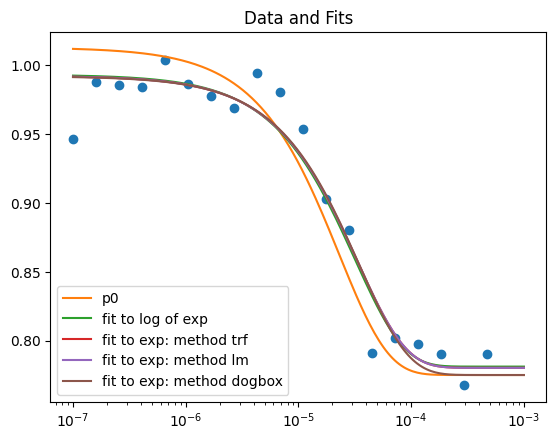

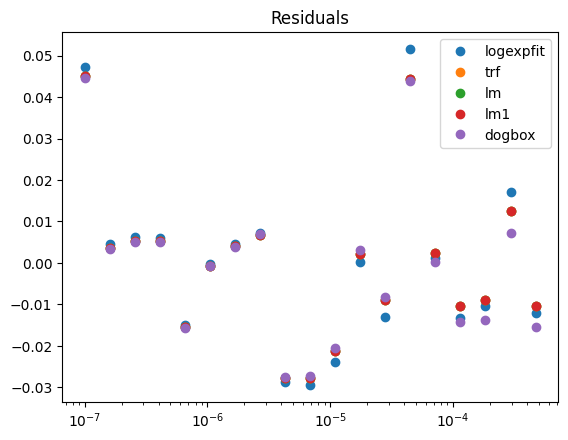

0.04576308609700952


In [18]:
# test for 2023-07-17-17-50-37-relaxation_laser as it looks like a good measurement
pulse_exp_dayfolder = Pulse_exp_dayfolders[1]
pulse_exp_timetag = '/2023-07-14-10-08-36'

pulse_exp_QS3_eval_file, pulse_exp_metadata = pSd.ReadSNVMfile(pulse_exp_dayfolder + '/relaxation_laser' 
                                                               + pulse_exp_timetag + '-relaxation_laser')
pulse_exp_relaxation_filename = pulse_exp_dayfolder + '/relaxation_laser' + pulse_exp_timetag +'-relaxation_laser/seq0/eval/Relaxation.h5'

pulse_exp_relaxation_file = h5py.File(pulse_exp_relaxation_filename)

delays = pSd.ExtractData(pulse_exp_relaxation_file, datatype = 'delay')[0][0]
ms0s = pSd.ExtractData(pulse_exp_relaxation_file, datatype = 'ms0')[0][0]
ref0s = pSd.ExtractData(pulse_exp_relaxation_file, datatype = 'ref0')[0][0]
contrasts = pSd.ExtractData(pulse_exp_relaxation_file, datatype = 'contrastms0')[0][0]

#print(delays)
print('Automatic evaluation gives T1 of:',pulse_exp_QS3_eval_file['data']['Relaxation:t1'][0][0])


p0 = [1/4.3,4e-5,0,0.78]
popt_logexpfit, pcov_logexpfit, infodict_logexpfit, mesg, ier = curve_fit(logofexp, delays[:-1], np.log(contrasts[:-1]),
                                                               p0=p0, method='lm', maxfev=100000, full_output=True)
                                                                #,bounds=[noCbounds_low,noCbounds_up])
print('fit to log:', popt_logexpfit,'\n', infodict_logexpfit['fvec'], np.mean(infodict_logexpfit['fvec']))

#plt.subplots()
#plt.plot(delays[:-1],contrasts[:-1],'o')
#plt.plot(np.logspace(-7,-3,200),np.exp(logofexp(np.logspace(-7,-3,200),*p0)),'-',label='p0')
#plt.plot(np.logspace(-7,-3,200),np.exp(logofexp(np.logspace(-7,-3,200),*popt_logexpfit)),'-',label='popt')
#plt.xscale('log')
#plt.legend()
#plt.show()

lowerbounds = [-np.inf,0,-np.inf,-np.inf]
upperbounds = [np.inf,np.inf,np.inf,np.inf]
p0 = [1/4.2,2.3e-5,0,0.775]
popt_expfit_trf, pcov_expfit_trf, infodict_expfit_trf, mesg, ier = curve_fit(exponential,delays[:-1], contrasts[:-1],
                                                                  p0=p0,bounds=[lowerbounds,upperbounds], 
                                                                  method='trf', full_output=True)
print('trf exp:', popt_expfit_trf,'\n', infodict_expfit_trf['fvec'], np.var(infodict_expfit_trf['fvec']))
#popt, pcov = curve_fit(logofexp,delays[:-1], contrasts[:-1])#,p0=p0,bounds=[lowerbounds,upperbounds])

popt_expfit_lm, pcov_expfit_lm, infodict_expfit_lm, mesg, ier = curve_fit(exponential,delays[:-1], contrasts[:-1],
                                                               p0=p0, method='lm', full_output=True)
print('lm exp p0:', popt_expfit_lm,'\n', infodict_expfit_lm['fvec'], np.var(infodict_expfit_lm['fvec']))
p0_1 = [1/4.3,4e-5,0,0.78]
popt_expfit_lm_1, pcov_expfit_lm_1, infodict_expfit_lm_1, mesg, ier = curve_fit(exponential,delays[:-1], contrasts[:-1],
                                                                     p0=p0, method='lm', full_output=True)
print('lm exp p0_1:', popt_expfit_lm_1,'\n', infodict_expfit_lm_1['fvec'], np.var(infodict_expfit_lm_1['fvec']))

popt_expfit_dogbox, pcov_expfit_dogbox, infodict_expfit_dogbox, mesg, ier = curve_fit(exponential,delays[:-1], contrasts[:-1],
                                                                           p0=p0,method='dogbox',maxfev=100000, 
                                                                           full_output=True)
print('dogbox exp:', popt_expfit_dogbox,'\n', infodict_expfit_dogbox['fvec'], np.var(infodict_expfit_dogbox['fvec']))

w_l = np.zeros_like(delays[:-1])
w_u = np.ones((12,))*0.4
w_l[6:18] = w_u
weights = w_l + 0.5

print(weights)

expModel = odr.Model(odrexp)
odrData = odr.Data(delays[1:-1],contrasts[1:-1],we = weights)
expodr = odr.ODR(odrData, expModel, beta0 = p0, maxit = 100000)
odrOutput = expodr.run()
print('ODR Fit:')
odrOutput.pprint()

plot_xarray = np.logspace(-7,-3,200)

plt.subplots()
plt.title('Data and Fits')
plt.plot(delays[:-1],contrasts[:-1],'o')
#plt.plot(delays[:-1],exponential(delays[:-1],*popt),'-')
plt.plot(plot_xarray,exponential(plot_xarray,*p0),'-',label = 'p0')
plt.plot(plot_xarray,exponential(plot_xarray,*popt_logexpfit),'-',label = 'fit to log of exp')
plt.plot(plot_xarray,exponential(plot_xarray,*popt_expfit_trf),'-',label = 'fit to exp: method trf')
plt.plot(plot_xarray,exponential(plot_xarray,*popt_expfit_lm),'-',label = 'fit to exp: method lm')
plt.plot(plot_xarray,exponential(plot_xarray,*popt_expfit_dogbox),'-',label = 'fit to exp: method dogbox')
#plt.plot(plot_xarray,exponential(plot_xarray,*odrOutput.beta),'-',label = 'fit to exp: odrexp')
#plt.plot(delays[:-1],(logofexp(delays[:-1],*popt)),'-')
#plt.plot(np.arange(1e-6,1e-3,1e-6),noCexp(logofexp(np.arange(1e-6,1e-3,1e-6),1,1e-1),1,1e-1))
plt.xscale('log')
plt.legend()
plt.show()



plt.subplots()
plt.title('Residuals')
#plt.plot(delays[:-1], contrasts[:-1],'o')
plt.plot(delays[:-1], (infodict_logexpfit['fvec']),'o',label='logexpfit')
plt.plot(delays[:-1], infodict_expfit_trf['fvec'],'o',label='trf')
plt.plot(delays[:-1], infodict_expfit_lm['fvec'],'o',label='lm')
plt.plot(delays[:-1], infodict_expfit_lm_1['fvec'],'o',label='lm1')
plt.plot(delays[:-1], infodict_expfit_dogbox['fvec'],'o',label='dogbox')
#plt.plot(delays[:-1], contrasts[:-1]-exponential(delays[:-1],*odrOutput.beta),'o',label='odrexp')
plt.xscale('log')
plt.legend()
plt.show()

#####  to check if overparametrized #########
#print(np.linalg.cond(pcov_expfit_trf))
#print(np.diag(pcov_expfit_trf))

# find noise of the measurement for simulation dataset

delta_y_to_fit = contrasts - exponential(delays,*popt_logexpfit)
print(np.max(np.abs(delta_y_to_fit)))


In [ ]:
x = delays[:-1]
sigma = 1e-6
mu = 3e-5
gauss = gaussian_pdf(x,sigma,mu)
weights = (gauss)

x = delays[:-1]
a = 1e5
x0 = 8e-5
b = 8e2
gauss = gaussian(x,x0,a,b)
weights = (gauss)

fig_test, ax_test = plt.subplots()
ax_test.plot(x,weights)
ax_test.set_xscale('log')
plt.show()


[ 0.         -0.01093836 -0.04379704 ... -0.02321967  0.03517387
  0.04165507]
------------------ popts from all iterations (down, 0 is initial params) and fit types (right) ----------------------
[logexpfit, trf, lm, lm1, dogbox, odrexp]





----------------------------- histogram calculation ---------------------------
[-0.54262869 -0.50944428 -0.47625986 -0.44307544 -0.40989103 -0.37670661
 -0.34352219 -0.31033778 -0.27715336 -0.24396895 -0.21078453 -0.17760011
 -0.1444157  -0.11123128 -0.07804687 -0.04486245 -0.01167803  0.02150638
  0.0546908   0.08787522  0.12105963  0.15424405  0.18742846  0.22061288
  0.2537973   0.28698171  0.32016613  0.35335054  0.38653496  0.41971938
  0.45290379  0.48608821  0.51927263  0.55245704  0.58564146  0.61882587
  0.65201029  0.68519471  0.71837912  0.75156354  0.78474796  0.81793237
  0.85111679  0.8843012   0.91748562  0.95067004  0.98385445  1.01703887
  1.05022328  1.0834077   1.11659212] [0.         0.03318442 0.06636883 0.09955325 0.1327376

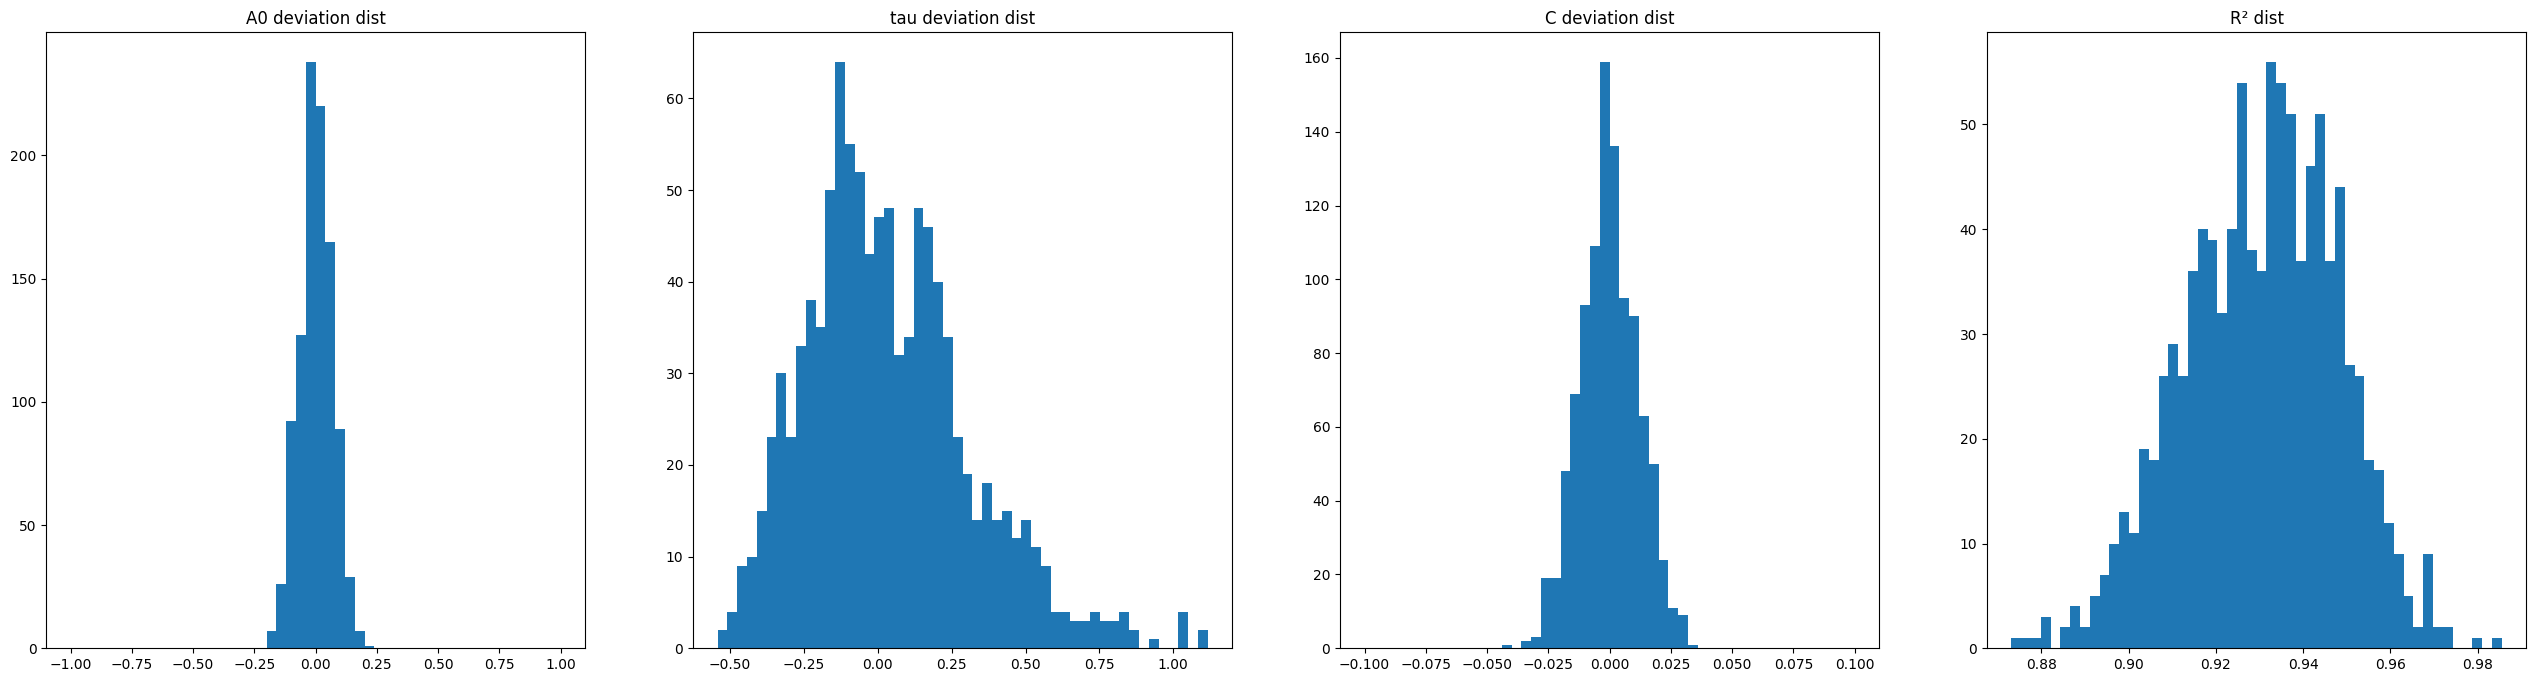

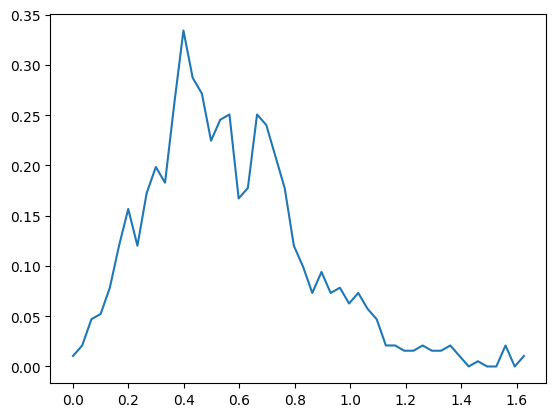

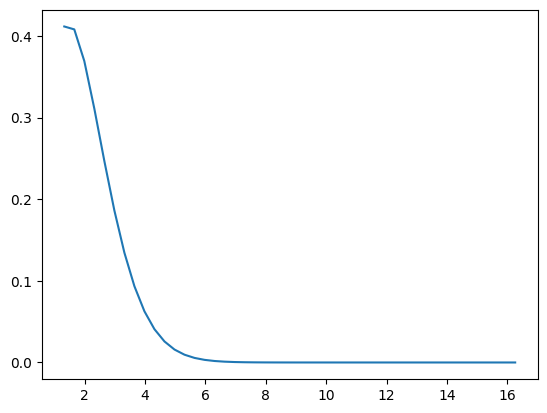

In [39]:
######### Test what's needed for a 'good' Relaxometry measurement #######

#warnings.filterwarnings('ignore')

A0 = 0.2
tau = 1.1e-5
C = 0.8

xminexp, xmaxexp = -8, -2
numpx = 20

noisefac = 0.05
noisefac = 0.04576 # from measurement 2023-07-14-10-08-36

nr_iter = 1000

x = np.logspace(xminexp,xmaxexp,numpx)

fig_fits, ax_fits = plt.subplots(figsize=(20,20))
ax_fits.set_axis_off()

fig_resids, ax_resids = plt.subplots(figsize=(20,20))
ax_resids.set_axis_off()

A0s = np.zeros((nr_iter+1,6)) #index_iter, index_fittype;      index_iter[0] is initial param
taus = np.zeros((nr_iter+1,6))
Cs = np.zeros((nr_iter+1,6))

A0s[0,:] = A0
taus[0,:] = tau
Cs[0,:] = C

variance_resids = np.zeros((nr_iter+1,6))
Rsquareds = np.zeros((nr_iter+1,6))


for i in range(nr_iter):

    ############ Plot initial data ###################
    
#    print('------------------- Iteration Nr ' + str(i+1) +' -------------------')
    
    y_init = exponentialNot0(x,A0,tau,C)
    noise = 2*(np.random.random(np.shape(y_init))-1/2) * noisefac
    y_init_noisy = y_init + noise
    ax_i_fits = fig_fits.add_subplot(ceil(np.sqrt(nr_iter)),ceil(np.sqrt(nr_iter)),i+1)
    ax_i_fits.plot(x,y_init_noisy,'o',label = 'initial noisy signal, iter '+str(i+1))

    SS_tot = np.sum((y_init_noisy-np.mean(y_init_noisy))**2) # total sum of squares

    
    ############### Fitting #################
    
    p0 = [0.25,2e-5,0.75]
    popt_logexpfit, pcov_logexpfit, infodict_logexpfit, mesg, ier = curve_fit(logofexpNot0, x, np.log(y_init_noisy),
                                                                   p0=p0, method='lm', maxfev=100000, full_output=True)
                                                                    #,bounds=[noCbounds_low,noCbounds_up])
#    print('fit to log:', popt_logexpfit,'\n', infodict_logexpfit['fvec'], np.mean(infodict_logexpfit['fvec']))

    A0s[i+1,0] = popt_logexpfit[0]
    taus[i+1,0] = popt_logexpfit[1]
    Cs[i+1,0] = popt_logexpfit[2]

    variance_resids[i+1,0] = np.var(infodict_logexpfit['fvec'])
    SS_res = np.sum(infodict_logexpfit['fvec']**2)
    Rsquareds[i+1,0] = 1 - (SS_res/SS_tot)
    
    #plt.subplots()
    #plt.plot(delays[:-1],contrasts[:-1],'o')
    #plt.plot(np.logspace(-7,-3,200),np.exp(logofexp(np.logspace(-7,-3,200),*p0)),'-',label='p0')
    #plt.plot(np.logspace(-7,-3,200),np.exp(logofexp(np.logspace(-7,-3,200),*popt_logexpfit)),'-',label='popt')
    #plt.xscale('log')
    #plt.legend()
    #plt.show()
    
    lowerbounds = [-np.inf,0,-np.inf]
    upperbounds = [np.inf,np.inf,np.inf]
    p0 = [0.25,2e-5,0.75]
    p0 = [0.15,1.3e-5,0.87]
    popt_expfit_trf, pcov_expfit_trf, infodict_expfit_trf, mesg, ier = curve_fit(exponentialNot0,x, y_init_noisy,
                                                                      p0=p0,bounds=[lowerbounds,upperbounds], 
                                                                      method='trf', maxfev=100000, full_output=True)
#    print('trf exp:', popt_expfit_trf,'\n', infodict_expfit_trf['fvec'], np.var(infodict_expfit_trf['fvec']))
    #popt, pcov = curve_fit(logofexp,delays[:-1], contrasts[:-1])#,p0=p0,bounds=[lowerbounds,upperbounds])

    A0s[i+1,1] = popt_expfit_trf[0]
    taus[i+1,1] = popt_expfit_trf[1]
    Cs[i+1,1] = popt_expfit_trf[2]

    variance_resids[i+1,1] = np.var(infodict_expfit_trf['fvec'])
    SS_res = np.sum(infodict_expfit_trf['fvec']**2)
    Rsquareds[i+1,1] = 1 - (SS_res/SS_tot)
    
    popt_expfit_lm, pcov_expfit_lm, infodict_expfit_lm, mesg, ier = curve_fit(exponentialNot0, x, y_init_noisy,
                                                                   p0=p0, method='lm', maxfev=100000, full_output=True)
#    print('lm exp p0:', popt_expfit_lm,'\n', infodict_expfit_lm['fvec'], np.var(infodict_expfit_lm['fvec']))

    A0s[i+1,2] = popt_expfit_lm[0]
    taus[i+1,2] = popt_expfit_lm[1]
    Cs[i+1,2] = popt_expfit_lm[2]

    variance_resids[i+1,2] = np.var(infodict_expfit_lm['fvec'])
    SS_res = np.sum(infodict_expfit_lm['fvec']**2)
    Rsquareds[i+1,2] = 1 - (SS_res/SS_tot)

    p0_1 = [1/4.3,4e-5,0,0.78]
    popt_expfit_lm_1, pcov_expfit_lm_1, infodict_expfit_lm_1, mesg, ier = curve_fit(exponentialNot0, x, y_init_noisy,
                                                                         p0=p0, method='lm', maxfev=100000, full_output=True)
#    print('lm exp p0_1:', popt_expfit_lm_1,'\n', infodict_expfit_lm_1['fvec'], np.var(infodict_expfit_lm_1['fvec']))

    A0s[i+1,3] = popt_expfit_lm_1[0]
    taus[i+1,3] = popt_expfit_lm_1[1]
    Cs[i+1,3] = popt_expfit_lm_1[2]

    variance_resids[i+1,3] = np.var(infodict_expfit_lm_1['fvec'])
    SS_res = np.sum(infodict_expfit_lm_1['fvec']**2)
    Rsquareds[i+1,3] = 1 - (SS_res/SS_tot)
    
    popt_expfit_dogbox, pcov_expfit_dogbox, infodict_expfit_dogbox, mesg, ier = curve_fit(exponentialNot0, x, y_init_noisy,
                                                                               p0=p0,method='dogbox', maxfev=100000, 
                                                                               full_output=True)
#    print('dogbox exp:', popt_expfit_dogbox,'\n', infodict_expfit_dogbox['fvec'], np.var(infodict_expfit_dogbox['fvec']))

    A0s[i+1,4] = popt_expfit_dogbox[0]
    taus[i+1,4] = popt_expfit_dogbox[1]
    Cs[i+1,4] = popt_expfit_dogbox[2]

    variance_resids[i+1,4] = np.var(infodict_expfit_dogbox['fvec'])
    SS_res = np.sum(infodict_expfit_dogbox['fvec']**2)
    Rsquareds[i+1,4] = 1 - (SS_res/SS_tot)
    
    w_l = np.ones_like(y_init_noisy)
    #w_u = np.ones((12,))*0.4
    #w_l[6:18] = w_u
    #weights = w_l + 0.5
    weights = w_l
    
#    print(weights)
    
    expModel = odr.Model(odrexp)
    odrData = odr.Data(x,y_init_noisy,we = weights)
    expodr = odr.ODR(odrData, expModel, beta0 = p0, maxit = 100000)
    odrOutput = expodr.run()
#    print('ODR Fit:')
#    odrOutput.pprint()
    
    A0s[i+1,5] = odrOutput.beta[0]
    taus[i+1,5] = odrOutput.beta[1]
    Cs[i+1,5] = odrOutput.beta[2]

    variance_resids[i+1,5] = np.var(y_init_noisy-exponentialNot0(x,*odrOutput.beta))
    SS_res = np.sum((y_init_noisy-exponentialNot0(x,*odrOutput.beta))**2)
    Rsquareds[i+1,5] = 1 - (SS_res/SS_tot)
    
    ###################### Plot fits and residuals #####################

    ax_i_fits.set_title('Data and Fits iteration '+str(i+1))
    ax_i_fits.plot(x,y_init,'-',label = 'initial')
    ax_i_fits.plot(x,exponentialNot0(x,*p0),'-',label = 'p0')
    ax_i_fits.plot(x,exponentialNot0(x,*popt_logexpfit),'-',label = 'fit to log of exp')
    ax_i_fits.plot(x,exponentialNot0(x,*popt_expfit_trf),'-',label = 'fit to exp: method trf')
    ax_i_fits.plot(x,exponentialNot0(x,*popt_expfit_lm),'-',label = 'fit to exp: method lm')
    ax_i_fits.plot(x,exponentialNot0(x,*popt_expfit_lm_1),'-',label = 'fit to exp: method lm1')
    ax_i_fits.plot(x,exponentialNot0(x,*popt_expfit_dogbox),'-',label = 'fit to exp: method dogbox')
    ax_i_fits.plot(x,exponentialNot0(x,*odrOutput.beta),'-',label = 'fit to exp: odrexp')
    ax_i_fits.set_xscale('log')
    #ax_i_fits.legend()

    ax_i_resids = fig_resids.add_subplot(ceil(np.sqrt(nr_iter)),ceil(np.sqrt(nr_iter)),i+1)

    ax_i_resids.set_title('Residuals iteration '+str(i+1))
    #plt.plot(delays[:-1], contrasts[:-1],'o')
    ax_i_resids.plot(x, infodict_logexpfit['fvec'],'o',label='logexpfit')
    ax_i_resids.plot(x, infodict_expfit_trf['fvec'],'o',label='trf')
    ax_i_resids.plot(x, infodict_expfit_lm['fvec'],'o',label='lm')
    ax_i_resids.plot(x, infodict_expfit_lm_1['fvec'],'o',label='lm1')
    ax_i_resids.plot(x, infodict_expfit_dogbox['fvec'],'o',label='dogbox')
    ax_i_resids.plot(x, y_init_noisy-exponentialNot0(x,*odrOutput.beta),'o',label='odrexp')
    ax_i_resids.set_xscale('log')
    ax_i_resids.legend()
    plt.clf()
    plt.cla()
    plt.close()



A0_deviations = (A0s-A0)/A0
tau_deviations = (taus-tau)/tau
C_deviations = (Cs-C)/C

A0_dev_trf = A0_deviations[:,1]
tau_dev_trf = tau_deviations[:,1]
C_dev_trf = C_deviations[:,1]

variance_tau_dev_trf = np.var(tau_dev_trf)

variance_resids_alliter = np.var(variance_resids, axis = 0)

print(A0_dev_trf)

print('------------------ popts from all iterations (down, 0 is initial params) and fit types (right) ----------------------')
print('[logexpfit, trf, lm, lm1, dogbox, odrexp]')
#print('A0s:', A0s)
#print('taus:', taus)
#print('Cs:', Cs)

print('\n')
#print('A0 deviations:', A0_deviations)
#print('tau deviations:', tau_deviations)
#print('C deviations:', C_deviations)
print()


#print('\n')
#print('variances of residuals for each iteration for different fitting methods:', variance_resids)
#print('variances (over all iterations) for different fitting methods:', variance_resids_alliter)
#print('FWHM from variances (over all iterations) for different fitting methods:', variance_resids_alliter*2*np.sqrt(2*np.log(2)))
#print('R² values for every iteration and fitting method:', Rsquareds )

print('\n')
nr_plots = 4
fig, ax = plt.subplots(nr_plots, figsize = (nr_plots*8,8))
ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()
ax[3].set_axis_off()
ax_A0devs = fig.add_subplot(1,nr_plots,1)
ax_A0devs.hist(A0_dev_trf,bins=50,range=(-1,1))
ax_A0devs.set_title('A0 deviation dist')
ax_taudevs = fig.add_subplot(1,nr_plots,2)
ax_taudevs.hist(tau_dev_trf,bins=50)
ax_taudevs.set_title('tau deviation dist')
ax_Cdevs = fig.add_subplot(1,nr_plots,3)
ax_Cdevs.hist(C_dev_trf,bins=50,range=(-0.1,0.1))
ax_Cdevs.set_title('C deviation dist')
ax_Rsqs = fig.add_subplot(1,nr_plots,4)
ax_Rsqs.hist(Rsquareds[1:,1],bins=50)#,range=(-0.1,0.1))
ax_Rsqs.set_title('R² dist')

print('----------------------------- histogram calculation ---------------------------')

fig, ax = plt.subplots()
tau_devs_hist, tau_devs_bins = np.histogram(tau_dev_trf,bins=50)
tau_devs_hist_normalized = normalize([tau_devs_hist])[0]
tau_devs_bins_shifted = tau_devs_bins-np.min(tau_devs_bins)
popt_tau_dev_hist, pcov_tau_dev_hist = curve_fit(poisson,tau_devs_bins_shifted[:-1]*10,tau_devs_hist_normalized)#,p0=[1,1,1])
ax.plot(tau_devs_bins_shifted[:-1],tau_devs_hist_normalized)

fig, ax = plt.subplots()
ax.plot(tau_devs_bins_shifted[:-1]*10,poisson(tau_devs_bins_shifted[:-1]*10,*popt_tau_dev_hist))
#ax.plot(test_x,poisson(test_x,20,0))
print(tau_devs_bins, tau_devs_bins_shifted,tau_devs_hist_normalized,poisson(tau_devs_bins_shifted[:-1],*popt_tau_dev_hist))
print('lambda',popt_tau_dev_hist[0], 'a',popt_tau_dev_hist[1], 'x0',popt_tau_dev_hist[2], 'variance of tau deviations',np.var(tau_dev_trf)) # poisson(x,lam,a,x0)



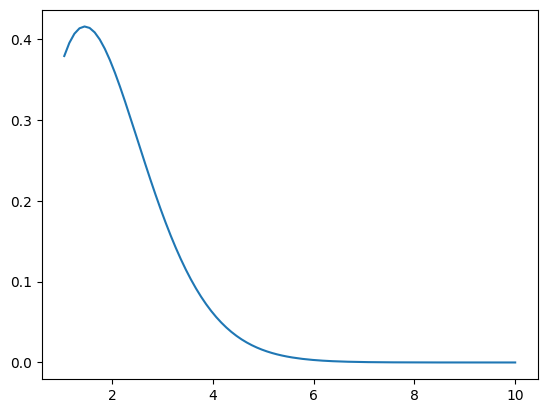

In [70]:
fig, ax = plt.subplots()
test_x = np.linspace(-10,10,200)
#ax.plot(tau_devs_bins[:-1],poisson(tau_devs_bins[:-1],*popt_tau_dev_hist))
ax.plot(test_x,poisson(test_x,1,1,1))

In [ ]:
A0 = 1.25e-1
tau = 5e-4
t0 = 0
C = 0.89

xmin=-6.5
xmax=-2.5

plt.subplots()
plt.plot(delays[:-1],contrasts[:-1],'o')
#plt.plot(delays[:-1],exponential(delays[:-1],1/8,0.0005,0,0.9),'-')
plt.plot(np.logspace(xmin,xmax,100),exponential(np.logspace(xmin,xmax,100),A0,tau,t0,C),'-',label=r'$e^x$')
#plt.plot(np.logspace(xmin,xmax,100),(1/2*exponential(0,A0,tau,t0,C)+C/2)*np.ones(np.shape(np.logspace(-6,-2,100))),'-')
#plt.axvline((-tau*np.log(0.5*np.exp(t0/tau))+t0))

plt.xscale('log')
plt.show()
#print((-tau*np.log(0.5*np.exp(t0/tau)-C/(2*A0))+t0))
print((-tau*np.log(0.5*np.exp(t0/tau))+t0))

In [ ]:
#############################################################

In [ ]:
noCbounds_low = [0,0]
noCbounds_up = [np.inf,np.inf]
noCp0 = [1/8,3e-5]
popt, pcov = curve_fit(noCexp,delays[:-1], contrasts[:-1],p0=noCp0,method='dogbox',bounds=[noCbounds_low,noCbounds_up])
print(popt)

plt.subplots()
plt.plot(delays[:-1],contrasts[:-1],'o')
plt.plot(np.logspace(-7,-3,200),noCexp(np.logspace(-7,-3,200),*noCp0),'-')
plt.plot(np.logspace(-7,-3,200),noCexp(np.logspace(-7,-3,200),*popt),'-')
plt.xscale('log')
plt.show()